## 4\. Model Building

Now that we have the data ready, its time to start making predictive models. I will go through 5 scikit-learn simple models including linear regression, decision tree and random forest.

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

I'll do the same thing later with H2O and XGboost

In [17]:
import pandas as pd
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math
import boto # to download from AWS S3 buckets


_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
#Let's define variables that will define the behaviour of the whole script
s3_path = 'http://bbts-kaggle.s3.amazonaws.com/bimbo/Pablo/'
use_validation=True # splits train data into train + val sets
val_week_threshold = 8 # (possible values 8 or 9)  - weeks 3,4,5,6,7 are train, and week 8.9 are val
trimmed = True # removes weeks which doesn't have all the lags. If False, fills empty lags with 0
lag = 5  # shifted mean_demand up to "lag" weeks
if (val_week_threshold == 8): lag = 4

In [3]:
#now we load our modified train and test set
tic()
sufix=""
if (use_validation): 
    sufix += "_holdout"
    sufix += repr(val_week_threshold)
if (trimmed): sufix += "_trimmed"

print ('Downloading File: train_modified{}.csv  ...'.format(sufix))
train = pd.read_csv("{}train_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   )

if (use_validation):
    print ('Downloading File: val_modified{}.csv  ...'.format(sufix))
    val = pd.read_csv("{}val_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   )  

print ('Downloading File: test_modified{}.csv  ...'.format(sufix))
test = pd.read_csv("{}test_modified{}.csv".format(s3_path,sufix),
                    dtype = {'id': 'uint32',
                            'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                      )
tac()

Time passed: 0hour:4min:27sec


In [4]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [14]:
from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    y = alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predictions = np.maximum(dtrain_predictions, 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])
    dval_predictions = np.maximum(dval_predictions, 0) 
    
    #Perform cross-validation: We are not using CV since the data has a temporal behavior, aka, time series.
    #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=2, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    #print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    #print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
    
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    #Plot Histogram of target and prediction distributions
    plt.hist(dval['log_target'], 100, alpha=0.5, label='target')
    plt.hist(dval_predictions, 100, alpha=0.5, label='predictions') 
    plt.legend(loc='upper right')
    plt.show()
    
    dtest[target] = np.maximum(dtest[target], 0) 
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    
    

In [15]:
# In case there is no validation, we make val = train
if not (use_validation):
    val = train.copy()

### Alg1 - Linear Regression Model

Lets make our first linear-regression model


Model Report
RMSLE TRAIN:  0.302137921871
RMSLE VAL:  0.537615985188
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  30128
MIN TARGET PREDICTED:  -0.104772984205
MEAN TARGET PREDICTED:  7.617320488638493
MAX TARGET PREDICTED:  8132.9888135


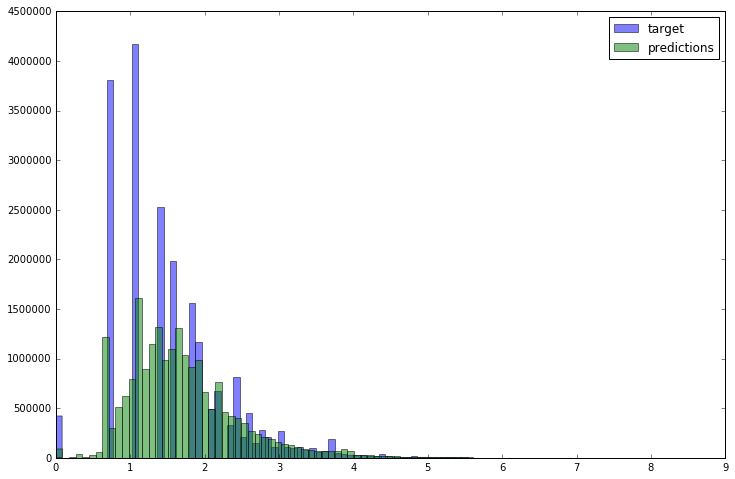

Time passed: 0hour:0min:46sec


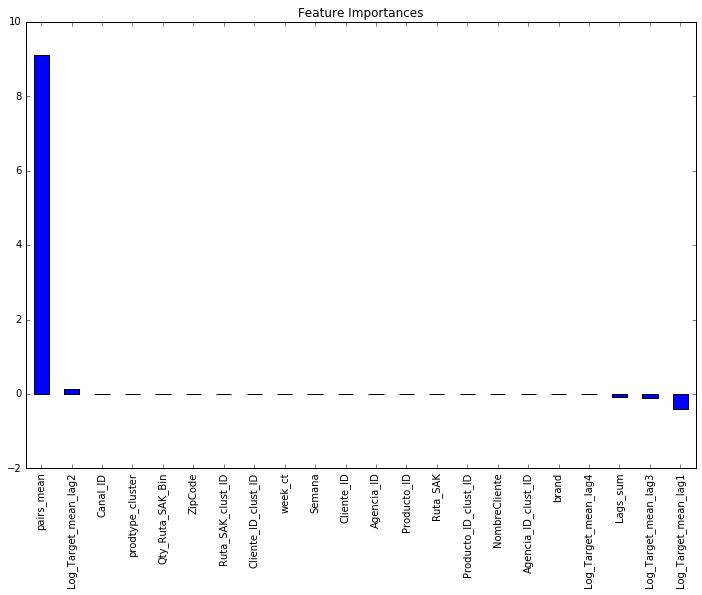

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+[IDcol]]

# print predictors
model = LinearRegression()
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg1_{}.csv'.format(sufix))
tac()

#Plot Coeficients importance
coef = pd.Series(model.coef_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')


The difference in rsmle in train vs val set is too high, this means overfitting.
We can see the reason of the overfit when looking at the coefficients, one in particular is very large in magnitude which causes the overfitting. To cater to this, lets use a ridge regression model.

### Alg2 - Ridge Regression Model:


Model Report
RMSLE TRAIN:  0.318960750841
RMSLE VAL:  0.511561196737
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0812264502981
MEAN TARGET PREDICTED:  5.901817669081464
MAX TARGET PREDICTED:  1994.37702348


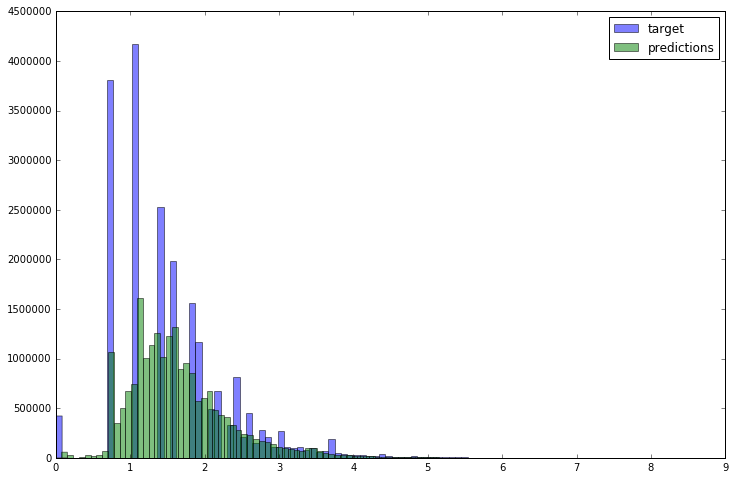

Time passed: 0hour:1min:33sec


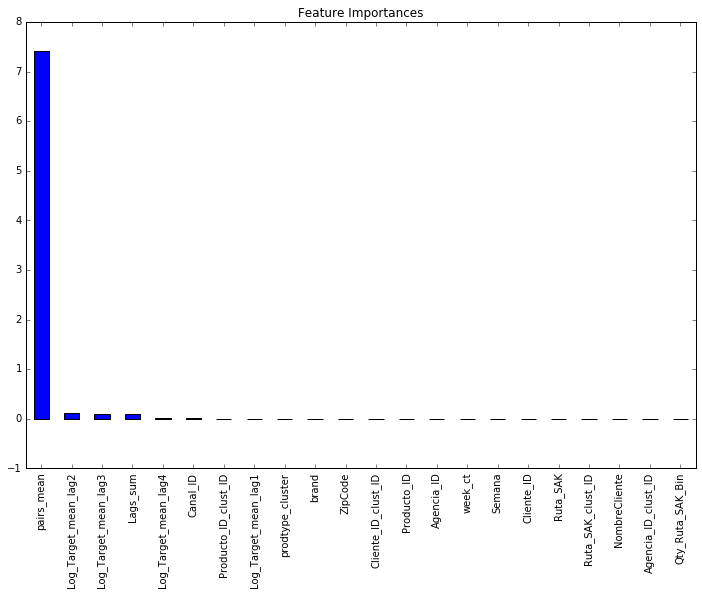

In [23]:
predictors = [x for x in train.columns if x not in [target]+[IDcol]]

model = Ridge(alpha=0.1, normalize=True, solver="sag")
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg2_{}.csv'.format(sufix))
tac()

#Plot Coeficients importance
coef = pd.Series(model.coef_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')


Though the train vs val rsmle difference is still high we noticed a improvement on the validation score, but still  the pairs_mean is taking all the weight/importance. We can tune the parameters of the model  but I don’t think there will be a significant improvement with linear regression.

Let's analize this behaviour for a minute, ~0.5 is basically the score of taking only pairs mean as the feature. This means that since pairs_mean is the average of demand per pair of product-client, we will be better of just doing the average and not do any machine learning at all (way faster). But I believe that the point of the competition is to predict, not to calculate an historical average. So let's remove it and actually try to predict.

Good news is that 0.51 is our baseline score we need to improve.

### Alg3 - Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSLE TRAIN:  0.4779750683
RMSLE VAL:  0.508771323742
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.00777472869477
MEAN TARGET PREDICTED:  5.04677980741714
MAX TARGET PREDICTED:  296.769656353


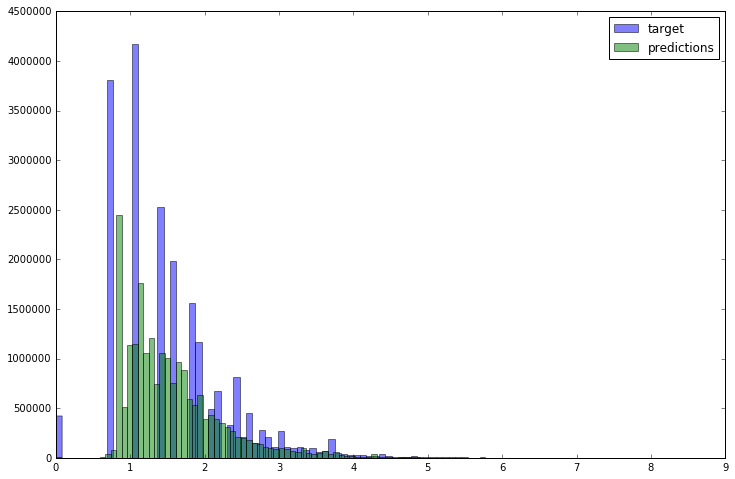

Time passed: 0hour:2min:56sec


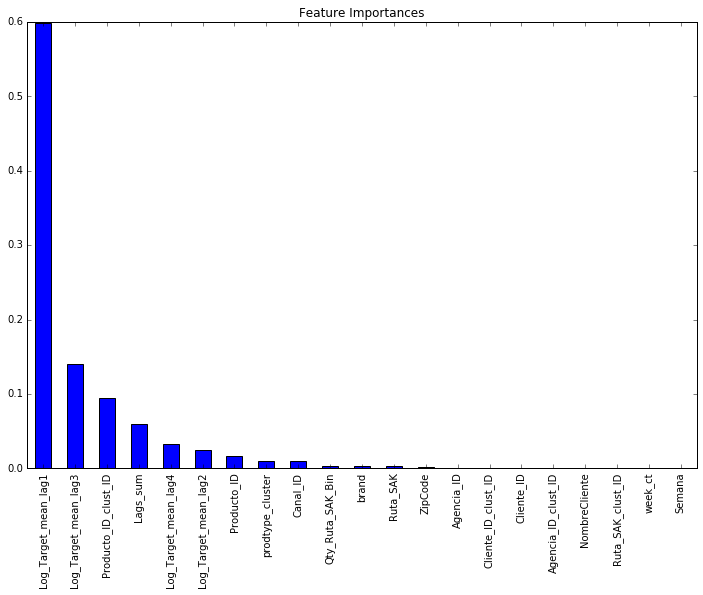

In [24]:
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
predictors.remove('pairs_mean')
    
model = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg3_{}.csv'.format(sufix))
tac()

#Plot Coeficients importance
coef = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')

### Bingo!
- RSMLE TRAIN vs RSMLE VAL is good, no sign of overfitting.
- Our score improved
- Some bad news is that the MAX TARGET PREDICTED is way different than the linear regression models. Min and Mean targets predicted look good though. This is an indication that the variance of our data is very high and our model cannot generalize well.

### Alg4 - Decision Tree Model v2

Lets try making a decision tree eliminating the variables with little importance, a max_depth of 25 and min_samples_leaf as 150.


Model Report
RMSLE TRAIN:  0.467175907276
RMSLE VAL:  0.504525877709
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0
MEAN TARGET PREDICTED:  4.808718361608939
MAX TARGET PREDICTED:  222.616650238


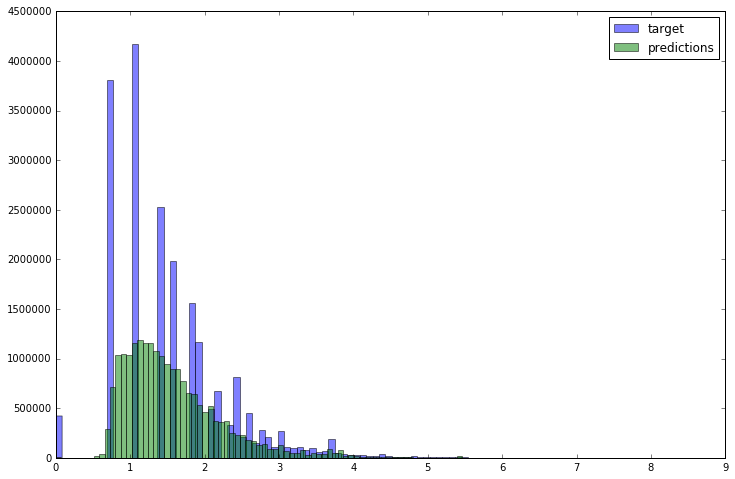

Time passed: 0hour:2min:7sec


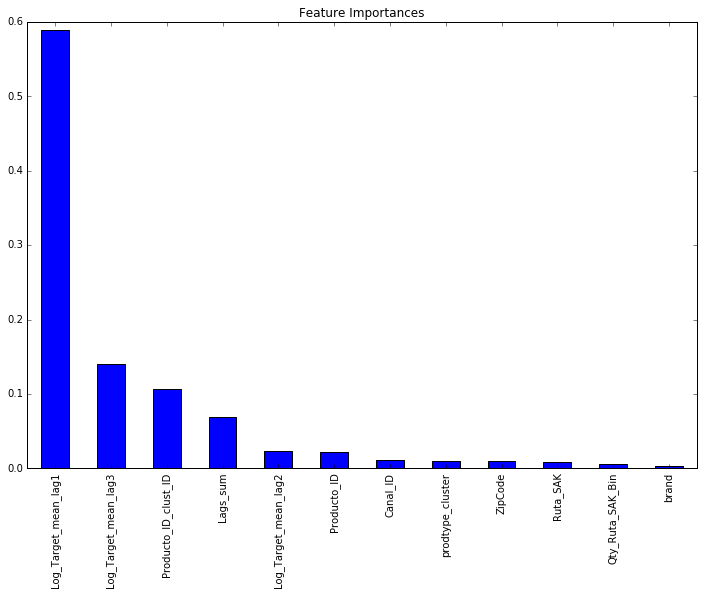

In [28]:
predictors = ['Producto_ID_clust_ID', 'Lags_sum', 'Producto_ID', 'prodtype_cluster', 'Canal_ID', 'Qty_Ruta_SAK_Bin', 'brand',
             'Ruta_SAK', 'ZipCode']              

for i in range(1,lag):
    predictors.insert(0,'Log_Target_mean_lag{}'.format(i))
    
    
model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=150)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg4_{}.csv'.format(sufix))
tac()

#Plot Coeficients importance
coef = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')

As expected, we improved our score further, deleted some useless features, but are still seeing the problem of MAX TARGET PREDICTED being way off the linear regression models / pairs mean.

Let's try some ensembling algos, starting with Random Forest which is an ensemble of the trees above. Score should improve by book definition :)

### Alg5 - Random Forest Model


Model Report
RMSLE TRAIN:  0.465939935349
RMSLE VAL:  0.499359476177
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0154672181406
MEAN TARGET PREDICTED:  4.70002454486359
MAX TARGET PREDICTED:  159.288439175


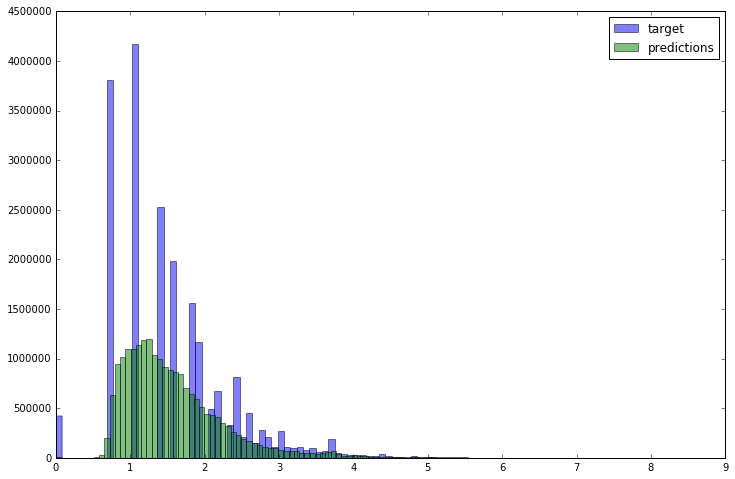

Time passed: 0hour:13min:27sec


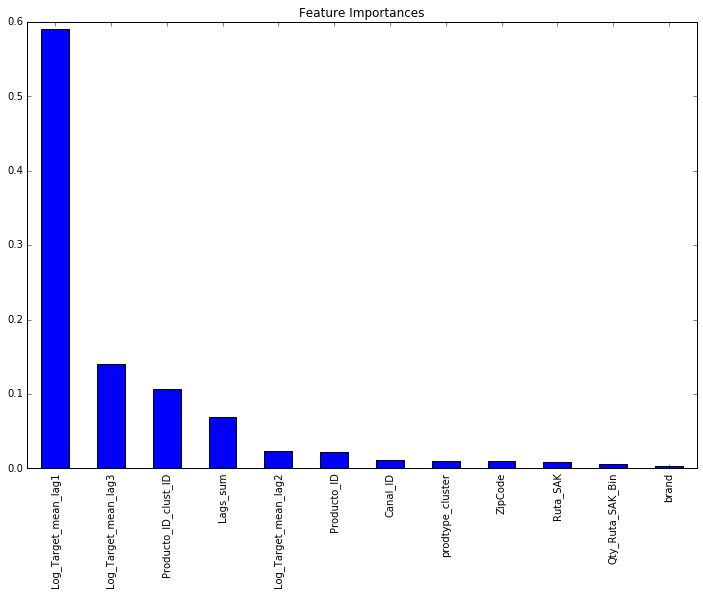

In [29]:
from sklearn.ensemble import RandomForestRegressor

predictors = ['Producto_ID_clust_ID', 'Lags_sum', 'Producto_ID', 'prodtype_cluster', 'Canal_ID', 'Qty_Ruta_SAK_Bin', 'brand',
             'Ruta_SAK', 'ZipCode']              
for i in range(1,lag):
    predictors.insert(0,'Log_Target_mean_lag{}'.format(i))
    
model = RandomForestRegressor(n_estimators=100,max_depth=25, min_samples_leaf=150,n_jobs=-1)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg5_{}.csv'.format(sufix))
tac()

#Plot Coeficients importance
coef = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')

As expected, better than a single tree. We can improve a little bit more if we add more estimators (trees), but Let's move on to more complex waters with XGBoost and H2O, where we also are going to deal with the fact that our MAX TARGET PREDICTED is very far from what it should be. This is a typical indication that our model is trying to predict clients that are very different in behaviour and we might not get too much better than this score. The solution to this is to create more granular models, or train as many models as client clusters are.

We just set a new bar: 0.47

See the next notebook ..